## Selecting feature for 2 times
### Author: Xu Haozhou
    - Due to the difference on random seed, you may need to try different random seed to get the best answer
    - The settings for the parameters in this file may not be the most suitable, you still need to do some adjustment.

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import sklearn
import scipy as sp
import statsmodels as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as vutils
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss

## Preparation

In [177]:
# Data are sorted in ./SuperData
Train_DataX = pd.read_csv("./SuperData/X_train.csv", index_col=[0], header=[0, 1, 2])
Valid_DataX = pd.read_csv("./SuperData/X_valid.csv", index_col=[0], header=[0, 1, 2])
Test_DataX = pd.read_csv('./SuperData/X_test.csv', header=[0,1,2], index_col=0)
Train_DataY = pd.read_csv("./task1/Y_train.csv", index_col=[0], header=[0])
Valid_DataY = pd.read_csv("./task1/Y_valid.csv", index_col=[0], header=[0])

In [178]:
# Fill the missing values
Train_DataX.fillna(0, inplace=True)
Valid_DataX.fillna(0, inplace=True)
Test_DataX.fillna(0, inplace=True)

# Get used columns
column_names = Train_DataX.columns
X_Train = Train_DataX[column_names]
X_valid = Valid_DataX[column_names]
X_Test = Test_DataX[column_names]

In [179]:
# Show size of Train_DataX
X_Train.shape

(16760, 7904)

In [180]:
# Shuffle the train data let Y = 0 and Y = 1 have 1:3 ratio
X_Train_0 = X_Train[Train_DataY["mort_icu"] == 0]
Y_Train_0 = Train_DataY[Train_DataY["mort_icu"] == 0]
X_Train_1 = X_Train[Train_DataY["mort_icu"] == 1]
Y_Train_1 = Train_DataY[Train_DataY["mort_icu"] == 1]

from sklearn.utils import shuffle
np.random.seed(1234)

X_Train_0, Y_Train_0 = shuffle(X_Train_0, Y_Train_0)
X_Train_0_use = X_Train_0[:int(len(X_Train_1)*3)]
Y_Train_0_use = Y_Train_0[:int(len(Y_Train_1)*3)]
X_Train_f = np.concatenate((X_Train_0_use, X_Train_1), axis=0)
Y_Train_f = np.concatenate((Y_Train_0_use, Y_Train_1), axis=0)

In [181]:
# Change each to numpy array
X_train = X_Train_f
X_valid = Valid_DataX.to_numpy()
X_test = X_Test.to_numpy()
Y_train = Y_Train_f
Y_valid = Valid_DataY.to_numpy()

In [182]:
X_train.shape

(4900, 7904)

In [183]:
Y_train = Y_train.ravel()
Y_valid = Y_valid.ravel()

## Step1

In [184]:
# Train X_train and Y_train by Ensemble model on the skewed data
from sklearn.ensemble import VotingClassifier
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# XGBoost
import xgboost as xgb

In [185]:
model = xgb.XGBClassifier(n_estimators=300, max_depth=6, min_child_weight=3, learning_rate=0.04, subsample=0.6, colsample_bytree=1, random_state=3612, eval_metric='auc', n_jobs=5)
model.fit(X_train, Y_train)

# Valid by X_valid and Y_valid
Y_valid_pred = model.predict(X_valid)
print("Accuracy: ", accuracy_score(Y_valid, Y_valid_pred))
print("Precision: ", precision_score(Y_valid, Y_valid_pred))
print("Recall: ", recall_score(Y_valid, Y_valid_pred))

Y_valid_prob = model.predict_proba(X_valid)[:,1]
print("AUC: ", roc_auc_score(Y_valid, Y_valid_prob))

Accuracy:  0.9256474519632414
Precision:  0.4368932038834951
Recall:  0.5921052631578947
AUC:  0.9120733367763745


In [186]:
importance = model.feature_importances_
# Construct a dataframe to show the importance of each feature
importance_df = pd.DataFrame(columns=column_names, data=[importance])

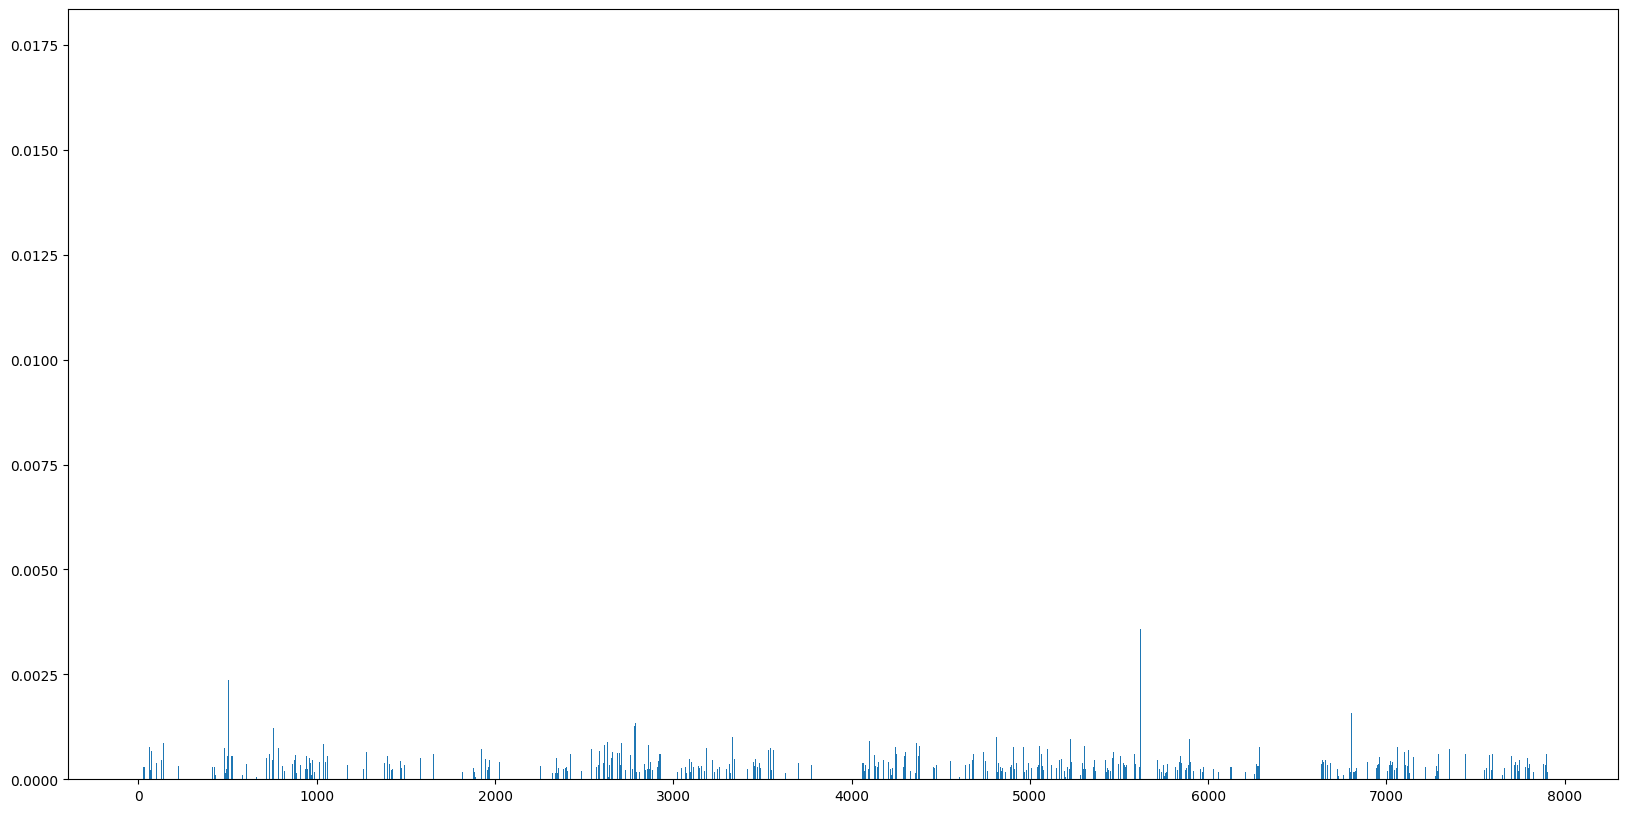

In [187]:
# Importance graph
x_axis = range(len(importance))
plt.figure(figsize=(20, 10))
plt.bar(x_axis, importance_df.iloc[0])
plt.show()

In [188]:
truetable_data1 = importance_df.values > np.mean(importance_df.values)
getcolumn = importance_df.columns[truetable_data1[0]]
importance_df.loc[:, getcolumn].to_csv("./T1feature/1-3-1_mean.csv", header=True)
getcolumn.shape

(2324,)

In [189]:
importance_df.loc[:, getcolumn]

LEVEL2               alanine aminotransferase                               \
Aggregation Function                     mean                                
hours_in                                    0        3         9        11   
0                                    0.000256  0.00029  0.000294  0.000145   

LEVEL2                                                                  \
Aggregation Function                                                     
hours_in                    13        16        17        18        21   
0                     0.000206  0.000387  0.000279  0.000247  0.000727   

LEVEL2                          ... white blood cell count urine            \
Aggregation Function            ...          time_since_measured             
hours_in                  diff  ...                           10        11   
0                     0.000586  ...                     0.000355  0.000137   

LEVEL2                                                                 \
Aggregation Function                                                    
hours_in                    12        13        14       18        19   
0                     0.000254  0.000345  0.000233  0.00025  0.000593   

LEVEL2                                             
Aggregation Function                               
hours_in                    20        22     diff  
0                     0.000635  0.000637  0.00018  

[1 rows x 2324 columns]

## Step 2

In [190]:
X_train = Train_DataX[getcolumn]
X_valid = Valid_DataX[getcolumn]
X_test = Test_DataX[getcolumn]

# Shuffle the train data let Y = 0 and Y = 1 have 1:3 ratio
X_Train_0 = X_train[Train_DataY["mort_icu"] == 0]
Y_Train_0 = Train_DataY[Train_DataY["mort_icu"] == 0]
X_Train_1 = X_train[Train_DataY["mort_icu"] == 1]
Y_Train_1 = Train_DataY[Train_DataY["mort_icu"] == 1]

from sklearn.utils import shuffle
np.random.seed(1234)

X_Train_0, Y_Train_0 = shuffle(X_Train_0, Y_Train_0)
X_Train_0_use = X_Train_0[:int(len(X_Train_1)*3)]
Y_Train_0_use = Y_Train_0[:int(len(Y_Train_1)*3)]
X_Train_f = np.concatenate((X_Train_0_use, X_Train_1), axis=0)
Y_Train_f = np.concatenate((Y_Train_0_use, Y_Train_1), axis=0)

# Change each to numpy array
X_train = X_Train_f
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_Train_f
Y_valid = Valid_DataY.to_numpy().ravel()

In [191]:
X_train.shape

(4900, 2324)

In [192]:
model = xgb.XGBClassifier(n_estimators=1000, max_depth=6, min_child_weight=3, learning_rate=0.04, subsample=0.6, colsample_bytree=1, random_state=3612, eval_metric='auc', n_jobs=5)
model.fit(X_train, Y_train)

# Valid by X_valid and Y_valid
Y_valid_pred = model.predict(X_valid)
print("Accuracy: ", accuracy_score(Y_valid, Y_valid_pred))
print("Precision: ", precision_score(Y_valid, Y_valid_pred))
print("Recall: ", recall_score(Y_valid, Y_valid_pred))

Y_valid_prob = model.predict_proba(X_valid)[:,1]
print("AUC: ", roc_auc_score(Y_valid, Y_valid_prob))

Accuracy:  0.9202172096908939
Precision:  0.41333333333333333
Recall:  0.6118421052631579
AUC:  0.9101777078736091


In [193]:
importance = model.feature_importances_
# Construct a dataframe to show the importance of each feature
importance_df = pd.DataFrame(columns=getcolumn, data=[importance])

In [194]:
truetable_data1 = importance_df.values > np.mean(importance_df.values)
getcolumn = importance_df.columns[truetable_data1[0]]
importance_df.loc[:, getcolumn].to_csv("./T1feature/1-3-2_mean.csv", header=True)
getcolumn.shape

(794,)

In [195]:
importance_df.loc[:, getcolumn]

LEVEL2               alanine aminotransferase                                \
Aggregation Function                     mean                                 
hours_in                                   11        13        17        21   
0                                    0.000622  0.000581  0.000485  0.000956   

LEVEL2                                                                  \
Aggregation Function           time_since_measured                       
hours_in                  diff                  11        13        14   
0                     0.000569            0.000659  0.000611  0.000619   

LEVEL2                                    ... white blood cell count  \
Aggregation Function                      ...                   mean   
hours_in                    15        17  ...                     19   
0                     0.000707  0.000435  ...               0.000444   

LEVEL2                                                                 \
Aggregation Function                    time_since_measured             
hours_in                    20       21                   8        10   
0                     0.000656  0.00045            0.000572  0.000493   

LEVEL2               white blood cell count urine                      \
Aggregation Function          time_since_measured                       
hours_in                                        8        19        20   
0                                        0.000811  0.000527  0.001281   

LEVEL2                                    
Aggregation Function                      
hours_in                    22      diff  
0                     0.000462  0.001496  

[1 rows x 794 columns]

## Step 3

In [196]:
X_train = Train_DataX[getcolumn]
X_valid = Valid_DataX[getcolumn]
X_test = Test_DataX[getcolumn]

# Shuffle the train data let Y = 0 and Y = 1 have 1:3 ratio
X_Train_0 = X_train[Train_DataY["mort_icu"] == 0]
Y_Train_0 = Train_DataY[Train_DataY["mort_icu"] == 0]
X_Train_1 = X_train[Train_DataY["mort_icu"] == 1]
Y_Train_1 = Train_DataY[Train_DataY["mort_icu"] == 1]

from sklearn.utils import shuffle
np.random.seed(1234)

X_Train_0, Y_Train_0 = shuffle(X_Train_0, Y_Train_0)
X_Train_0_use = X_Train_0[:int(len(X_Train_1)*3)]
Y_Train_0_use = Y_Train_0[:int(len(Y_Train_1)*3)]
X_Train_f = np.concatenate((X_Train_0_use, X_Train_1), axis=0)
Y_Train_f = np.concatenate((Y_Train_0_use, Y_Train_1), axis=0)

# Change each to numpy array
X_train = X_Train_f
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_Train_f
Y_valid = Valid_DataY.to_numpy().ravel()

In [197]:
X_train.shape

(4900, 794)

In [198]:
model = xgb.XGBClassifier(n_estimators=1000, max_depth=6, min_child_weight=3, learning_rate=0.04, subsample=0.6, colsample_bytree=1, random_state=3612, eval_metric='auc', n_jobs=5)
model.fit(X_train, Y_train)

# Valid by X_valid and Y_valid
Y_valid_pred = model.predict(X_valid)
print("Accuracy: ", accuracy_score(Y_valid, Y_valid_pred))
print("Precision: ", precision_score(Y_valid, Y_valid_pred))
print("Recall: ", recall_score(Y_valid, Y_valid_pred))

Y_valid_prob = model.predict_proba(X_valid)[:,1]
print("AUC: ", roc_auc_score(Y_valid, Y_valid_prob))

Accuracy:  0.9214703425229741
Precision:  0.4189189189189189
Recall:  0.6118421052631579
AUC:  0.9087926663223626


In [199]:
importance = model.feature_importances_
# Construct a dataframe to show the importance of each feature
importance_df = pd.DataFrame(columns=getcolumn, data=[importance])

In [200]:
truetable_data1 = importance_df.values > np.mean(importance_df.values)
getcolumn = importance_df.columns[truetable_data1[0]]
importance_df.loc[:, getcolumn].to_csv("./T1feature/1-3-3_mean.csv", header=True)
getcolumn.shape

(249,)

In [201]:
importance_df.loc[:, getcolumn]

LEVEL2               alanine aminotransferase                                \
Aggregation Function                     mean time_since_measured             
hours_in                                 diff                  15        17   
0                                    0.001359            0.001903  0.001768   

LEVEL2                         albumin                                         \
Aggregation Function              mean                                          
hours_in                  diff       0         1        2         8         9   
0                     0.001552  0.0016  0.001261  0.00126  0.001554  0.001927   

LEVEL2                          ... tidal volume set            \
Aggregation Function            ...             mean             
hours_in                    10  ...                9        18   
0                     0.001325  ...         0.006342  0.001646   

LEVEL2                                   tidal volume spontaneous  \
Aggregation Function time_since_measured                     mean   
hours_in                              14                       12   
0                               0.001664                 0.001298   

LEVEL2                     total protein    weight                     \
Aggregation Function time_since_measured      mean                      
hours_in                              10         0         1       22   
0                               0.001699  0.001537  0.001363  0.00168   

LEVEL2                                              
Aggregation Function           time_since_measured  
hours_in                    23                  12  
0                     0.001504            0.001396  

[1 rows x 249 columns]

## Result

In [202]:
Y_valid_pred

array([0, 1, 0, ..., 1, 0, 0])

In [203]:
# Count number of 1 in Y_valid_pred
print("Y_valid_pred has", sum(Y_valid_pred), "1s")

Y_valid_pred has 222 1s


In [204]:
Y_valid

array([0, 0, 0, ..., 1, 0, 0])

In [205]:
# Count number of 1 in Y_valid
print("Y_valid has", sum(Y_valid), "1s")

Y_valid has 152 1s


In [206]:
# Show the confusion matrix
cm = confusion_matrix(Y_valid, Y_valid_pred)
print(cm)

[[2113  129]
 [  59   93]]


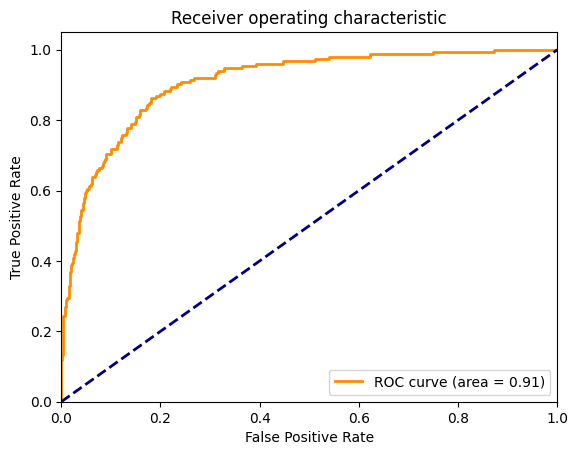

AUC:  0.9087926663223626


In [207]:
# Plot the roc curve
fpr, tpr, thresholds = roc_curve(Y_valid, Y_valid_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("AUC: ", roc_auc)

In [208]:
# if auc > 0.90, output the result by X_test
if roc_auc > 0.90:
    Y_test_prob = model.predict_proba(X_test)[:,1]
    index = X_Test.index
    output = pd.DataFrame(Y_test_prob, columns=['Predicted'], index=index, dtype=float)
    print(output.head())
    output.to_csv('output.csv', index_label='Id')

                  Predicted
32_175413_295037   0.070081
33_176176_296681   0.000680
42_119203_210828   0.001581
44_181750_291554   0.000096
61_176332_252348   0.001981
